# Вычислительная математика. Домашняя лабораторная работа №3.

## Выполнил: Хайдари Фарид, Б01 - 008.
## Номер: XI.9.2 (б)

Дано:

![alt text](task.jpg "Дано")

Понизим порядок

$$
\begin{cases}
v' = \frac{v^2}{y - 2} \\
y' = v \\
y(0) = y_0 \\
y(1) = 0
\end{cases}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def F(t, u):
    y = u[0]
    v = u[1]
    return np.array([v, v**2 / (y - 2)])

def runge_kutta4_iteration(f, h, argi, ui):
    k1 = f(argi, ui)
    k2 = f(argi + h / 2, ui + h * k1 / 2)
    k3 = f(argi + h / 2, ui + h * k2 / 2)
    k4 = f(argi + h, ui + h * k3)
    return ui + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6

def runge_kutta4(f, h, t_start, t_end, u0):
    t_num = int((t_end - t_start) / h + 1)
    t = np.linspace(t_start, t_end, t_num)

    u = np.zeros((t_num, 2))
    u[0] = u0

    for i in range(t_num - 1):
        u[i + 1] = runge_kutta4_iteration(f, h, t[i], u[i])

    return u

#### Решение вспомогательной задачи

$$
\begin{cases}
v' = f(x, y, v) \\
y' = v \\
y(0) = y_0 \\
v(0) = \alpha
\end{cases}
$$

Продифференцируем по $\alpha$:

$$
\begin{cases}
\frac{d}{dx} \left(\frac{\partial v}{\partial \alpha} \right) = \frac{\partial f}{\partial y} \frac{\partial y}{\partial \alpha} + \frac{\partial f}{\partial v} \frac{\partial v}{\partial \alpha} \\
\frac{d}{dx} \left(\frac{\partial y}{\partial \alpha} \right) = \frac{\partial v}{\partial \alpha} \\
\frac{\partial y}{\partial \alpha}(0) = 0 \\
\frac{\partial v}{\partial \alpha}(0) = 1
\end{cases}
$$

Введём обозначения:

$$
a := \frac{\partial y}{\partial \alpha} \\
b := \frac{\partial v}{\partial \alpha}
$$

т.о.

$$
\begin{cases}
\frac{db}{dx} = a \frac{\partial f}{\partial y} + b \frac{\partial f}{\partial u} \\ 
\frac{da}{dx} = b \\
a(0) = 0 \\
b(0) = 1
\end{cases}
$$



In [2]:
def solve_aux(f, h, x_start, x_end, u0):
    x_num = int((x_end - x_start) / h + 1)
    x = np.linspace(x_start, x_end, x_num)

    u = np.zeros((x_num, 2))
    u[0] = u0

    ab = np.zeros((x_num, 2))
    ab[0] = np.array([0, 1])

    for i in range(x_num - 1):
        u[i + 1] = runge_kutta4_iteration(f, h, x[i], u[i])

        yi, ui = u[i]
        df_dy = -ui**2 / (yi - 2)**2
        df_du = 2 * ui / (yi - 2)

        G = lambda _, ab: np.array([ab[1], ab[0] * df_dy + ab[1] * df_du])
        ab[i + 1] = runge_kutta4_iteration(G, h, x[i], ab[i])

    A, _ = ab.T
    return u, A[-1]

In [3]:
def binary_search(a_from, a_to, eps, f, h, t_start, t_end, y0):
    y, v = runge_kutta4(f, h, t_start, t_end, np.array([y0, a_to])).T
    y_last = y[-1]

    a = 0
    while abs(y_last) > eps:
        a = (a_from + a_to) / 2
        y, v = runge_kutta4(f, h, t_start, t_end, np.array([y0, a])).T

        y_last = y[-1]
        if y_last < 0:
            a_from = a
        else:
            a_to = a

    return y, v, a

def shooting(a0, eps, f, h, t_start, t_end, y0):
    res = solve_aux(F, h, t_start, t_end, np.array([y0, a0]))
    y, _ = res[0].T

    df_da = res[1]
    y_last = y[-1]

    a_prev = a_next = a0
    while abs(y_last) > eps:
        a_prev = a_next
        a_next = a_prev - y_last / df_da

        sol0 = np.array([y0, a_next])
        res = solve_aux(F, h, t_start, t_end, sol0)
        y, _ = res[0].T

        df_da = res[1]
        y_last = y[-1]
    
    return y, a_next



In [4]:
plt.style.use('Solarize_Light2')

def draw(a, x, y):
    plt.plot(x, y)
    plt.title(f"y(1) = {round(y[-1], 3)}, $\\alpha = ${round(a, 3)}")
    plt.ylabel('y')
    plt.xlabel('x')
    plt.grid()

In [5]:
h = 0.01

x_start, x_end = 0, 1
x_num = int((x_end - x_start) / h + 1)
x = np.linspace(x_start, x_end, x_num)

y0 = 1.95
y0_list = np.array([0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.95])

eps = 1e-6

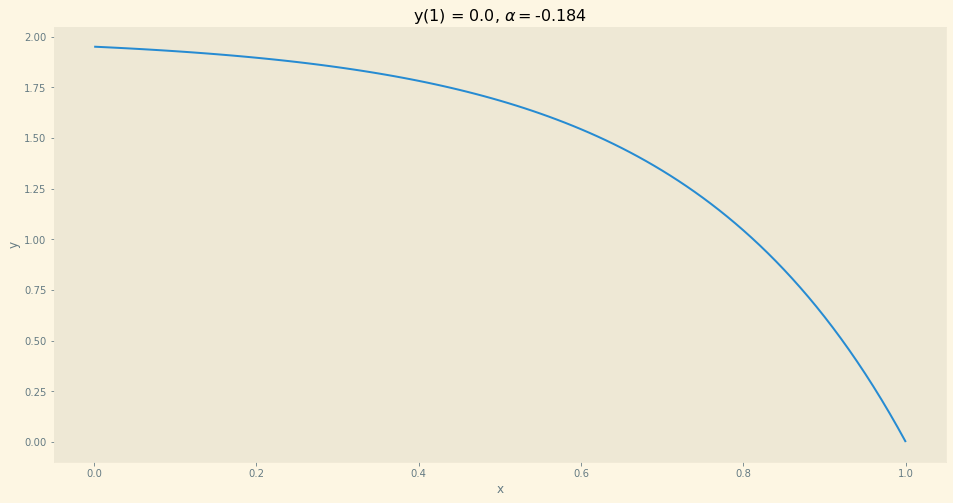

In [6]:
y, u, a = binary_search(-1, 1, eps, F, h, x_start, x_end, y0)
plt.figure(figsize=[16, 8])
draw(a, x, y)

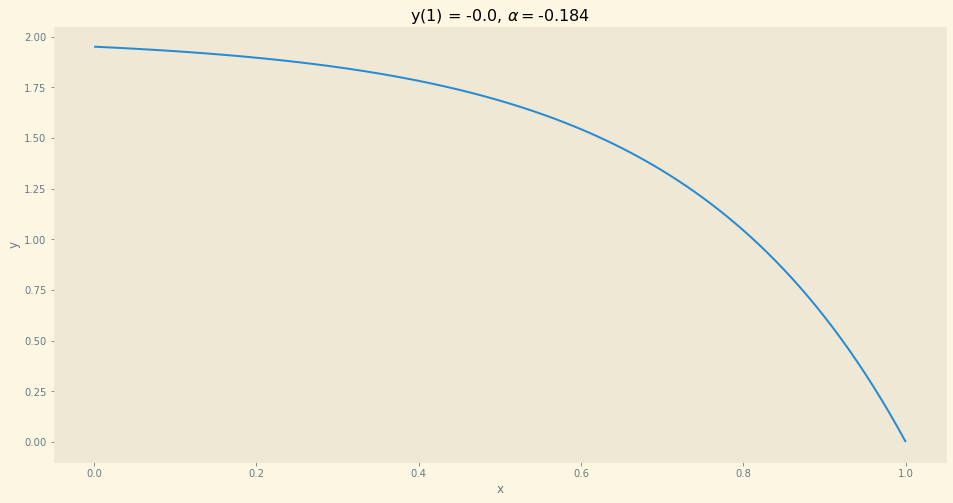

In [7]:
a0 = -1
y, a = shooting(a0, eps, F, h, x_start, x_end, y0)

plt.figure(figsize=[16, 8])
draw(a, x, y)

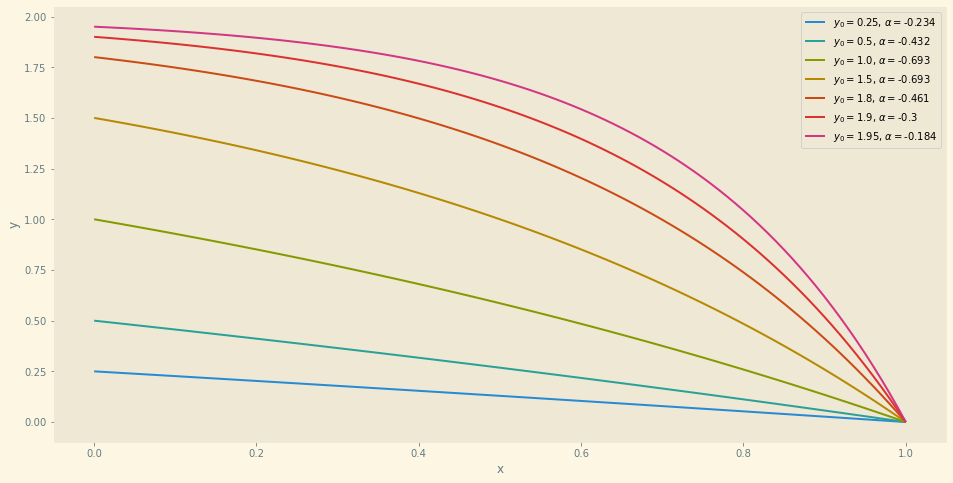

In [8]:
plt.figure(figsize=[16, 8])
for y0 in y0_list:
    y, a = shooting(a0, eps, F, h, x_start, x_end, y0)
    plt.plot(x, y, label=f"$y_0 = ${y0}, $\\alpha = ${round(a, 3)}")
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend()
    plt.grid()
